# Intro

## Teams

Data Section 1 file: MTeams.csv and WTeams.csv

These files identify the different college teams present in the dataset .

    TeamID - a 4 digit id number, uniquely identifying each NCAA® men's or women's team. A school's TeamID does not change from one year to the next, so for instance the Duke men's TeamID is 1181 for all seasons. The men's team ID's range from 1000-1999, whereas all of the women's team ID's range from 3000-3999.
    TeamName - a compact spelling of the team's college name, 16 characters or fewer.
    FirstD1Season - the first season in our dataset that the school was a Division-I school. This column is only present in the men's data, so it is not found in WTeams.csv.
    LastD1Season - the last season in our dataset that the school was a Division-I school. For any teams that are currently Division-I, they will be listed with LastD1Season=2025. Again, this column is only present in the men's data, so it is not found in WTeams.csv.


# Imports

In [ ]:
pip install pandas, matplotlib, seaborn

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'pandas,': Expected end or semicolon (after name and no valid version specifier)
    pandas,
          ^


In [26]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File import

In [4]:
men_teams = pd.read_csv("../../data/MTeams.csv")

In [5]:
men_teams.head

<bound method NDFrame.head of      TeamID        TeamName  FirstD1Season  LastD1Season
0      1101     Abilene Chr           2014          2025
1      1102       Air Force           1985          2025
2      1103           Akron           1985          2025
3      1104         Alabama           1985          2025
4      1105     Alabama A&M           2000          2025
..      ...             ...            ...           ...
375    1476       Stonehill           2023          2025
376    1477  East Texas A&M           2023          2025
377    1478        Le Moyne           2024          2025
378    1479      Mercyhurst           2025          2025
379    1480    West Georgia           2025          2025

[380 rows x 4 columns]>

In [6]:
men_scores_compact = pd.read_csv("../../data/MRegularSeasonCompactResults.csv")

In [7]:
men_scores_compact.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [9]:
men_scores_compact.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT'],
      dtype='object')

In [10]:
men_plays = men_scores_compact.drop(columns=['Season', 'DayNum','WScore', 'LScore', 'WLoc','NumOT' ])

In [12]:
men_plays.columns

Index(['WTeamID', 'LTeamID'], dtype='object')

In [16]:
occurrences = men_plays.groupby(['WTeamID', 'LTeamID']).size().reset_index(name='count')

In [19]:
occurrences.sort_values(by='count', ascending=False)

,WTeamID,LTeamID,count
14598,1242,1243,84
11479,1211,1388,74
11463,1211,1360,74
11465,1211,1362,73
11456,1211,1339,72
...,...,...,...
11,1101,1176,1
10,1101,1170,1
8,1101,1152,1
7,1101,1149,1


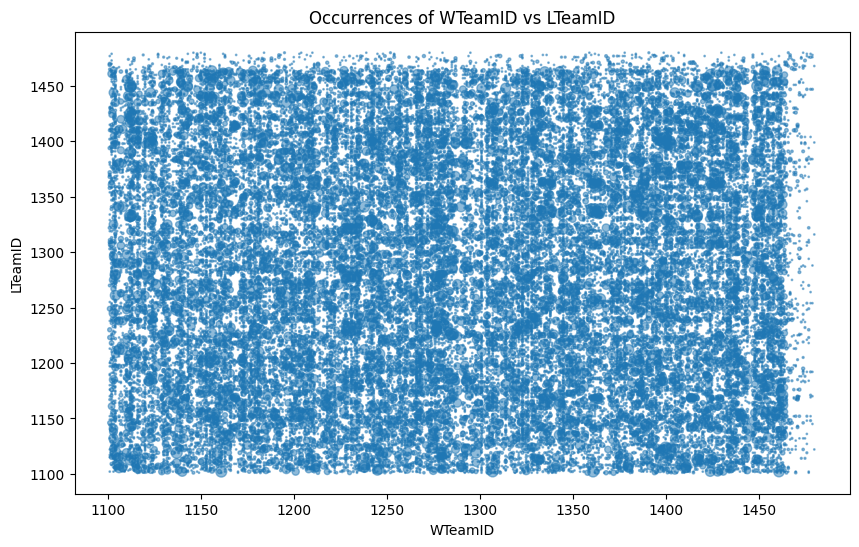

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(occurrences['WTeamID'], occurrences['LTeamID'], s=occurrences['count'], alpha=0.5)
plt.xlabel('WTeamID')
plt.ylabel('LTeamID')
plt.title('Occurrences of WTeamID vs LTeamID')
plt.show()

In [32]:
occurrences

,WTeamID,LTeamID,count
0,1101,1102,1
1,1101,1115,1
2,1101,1117,1
3,1101,1122,1
4,1101,1132,1
...,...,...,...
39759,1479,1478,1
39760,1480,1122,1
39761,1480,1316,1
39762,1480,1399,1


Let's see what's the proportion of wins for each pair of teams

# Using the Page-Rank algorithm